# Homework 4

In this homework we will practice basic analysis such as feature extraction and data transforms (Fourier, wavelet), and feature extraction.


**1. Ice-shelf seismograms** (10 points)

Time-domain filtering, 1D Fourier transform.

**2. TEC from the Hunga-Tunga explosion** (10 points)

Time-domain filtering, 1D wavelet transform.

**3. 2D Crustal model** (10 points)

practice reading netcdf, making maps and exploring 2D spectral content.



## 1) Time Frequency analysis of iceshelf vibrations 

We will explore the spectral content of the vibrations felt on iceshelves. We first download seismic data, then filter it at different frequency bandwidths, then plot the spectrogram and comment on the data.

The seismic data is handled by the Obspy package. Review the obspy tutorial that Ariane.
We will download the data presented in: Aster, R.C., Lipovsky, B.P., Cole, H.M., Bromirski, P.D., Gerstoft, P., Nyblade, A., Wiens, D.A. and Stephen, R., 2021. Swell‐Triggered Seismicity at the Near‐Front Damage Zone of the Ross Ice Shelf. Seismological Research Letters. https://doi.org/10.1785/0220200478

__Tips__:
1. Check out the SciPy filtering help here: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html. Obspy has built in functions as well, but for the sake of practicing, explore the scipy filtering functions.

2. The usual steps to handling seismic data are: data download (``get_waveforms``) & removing the instrumental response (``remove_response``).




**a. Import the relevant Obspy python modules (1 point).**

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal as signal
# Import the Obspy modules that will be useful to download seismic data
import obspy
import obspy.clients.fdsn.client as fdsn
from obspy import UTCDateTime

**b. Data download (1 point)**

We will now download the data from station "DR01" from seismic network "XH", channel "LHN" from 1/1/2015 until 3/31/2015. The client will be the "IRIS" data center. Obspy functions take on UTCDateTime formatted obspy datetime object, be sure to call or import that specific function. (1 point)

In [3]:
# answer below
# Download seismic data
network = 'XH'
station = 'DR01'
channel = 'LHN'
Tstart = UTCDateTime(year=2015, month=1, day=1)
Tend = UTCDateTime(year=2015, month=1, day=3)
fdsn_client = fdsn.Client('IRIS')
Z = fdsn_client.get_waveforms(network=network, station=station, location='--', channel=channel, starttime=Tstart, \
    endtime=Tend, attach_response=True)
Z.merge(); Z.detrend(type='linear')


1 Trace(s) in Stream:
XH.DR01..LHN | 2015-01-01T00:00:00.000000Z - 2015-01-03T00:00:00.000000Z | 1.0 Hz, 172801 samples

In [4]:
# how many days did we download?
dt=Tend-Tstart # in seconds
Ndays = int(dt/86400) # in days
print(Ndays)

2


**c. Time series filtering (2 points)**

Now we will filter the trace to explore its frequency content. We will apply 3 filters:
1. a ``lowpass`` filter to look at seismic frequencies below 0.01Hz, or 100 s period

2. a ``bandpass`` filter to look at seismic frequencies between 0.01Hz-0.1 Hz (10-100s)

3. a ``highpass`` filter to look at seismic frequencies higher than 0.1 Hz (10s) and until the time series Nyquist frequency (0.5Hz since the data is sampled at 1 Hz).

Text(0.5, 1.0, 'Highpass filter')

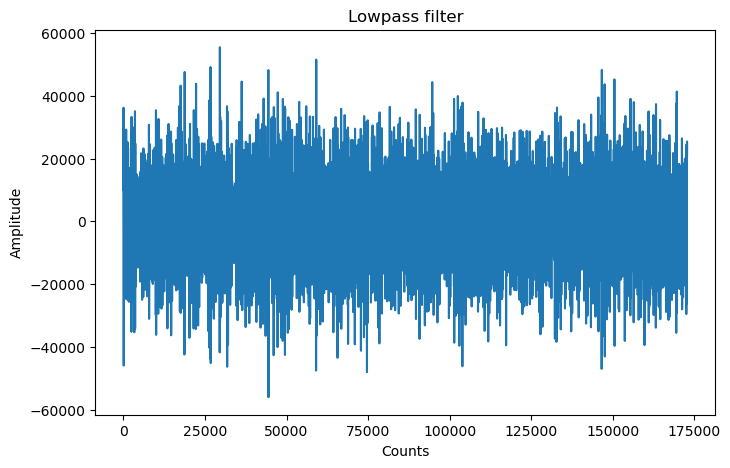

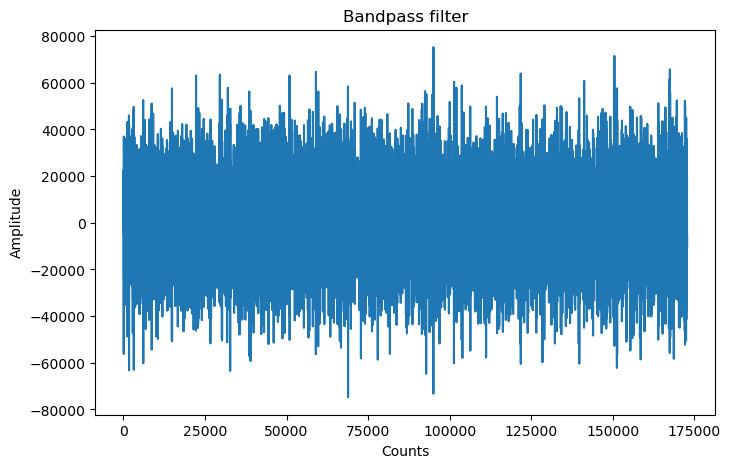

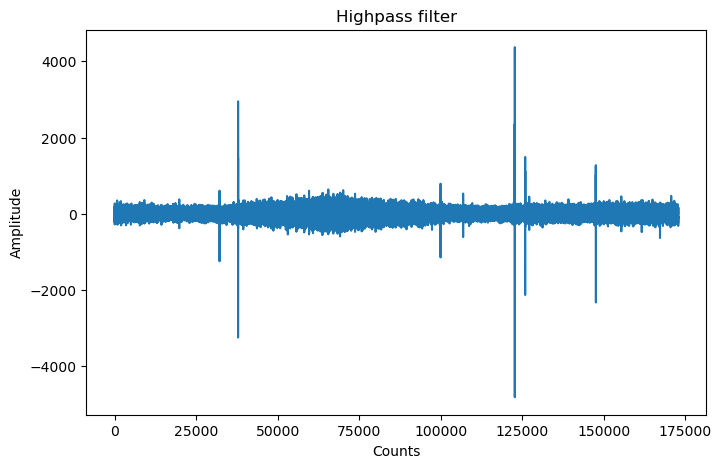

In [18]:
# answer below
from scipy.signal import butter,buttord,  sosfiltfilt, freqs

# sampling rate of the data:
fs = Z[0].stats.sampling_rate
t=np.arange(0,Z[0].stats.npts/Z[0].stats.sampling_rate,Z[0].stats.delta)
#t=np.arange(0.,7200.,1./fs)

sos_low = signal.butter(2, 0.01, btype='lowpass', fs=fs, output='sos')
zf_low = signal.sosfiltfilt(sos_low, Z[0])
fig, ax1 = plt.subplots(1,1, figsize=(8,5))
ax1.plot(t, zf_low)
ax1.set_xlabel("Counts")
ax1.set_ylabel("Amplitude")
ax1.set_title("Lowpass filter")

sos_bp = signal.butter(2,[0.01,0.1], btype='bandpass', fs=fs, output='sos')
zf_bp = signal.sosfiltfilt(sos_bp, Z[0])
fig, ax2 = plt.subplots(1,1, figsize=(8,5))
ax2.plot(t, zf_bp)
ax2.set_xlabel("Counts")
ax2.set_ylabel("Amplitude")
ax2.set_title("Bandpass filter")

sos_high = signal.butter(2,0.1, btype='highpass', fs=fs, output='sos')
zf_high = signal.sosfiltfilt(sos_high, Z[0])
fig, ax3 = plt.subplots(1,1, figsize=(8,5))
ax3.plot(t, zf_high)
ax3.set_xlabel("Counts")
ax3.set_ylabel("Amplitude")
ax3.set_title("Highpass filter")

# Here we use a Butterworth filter to select the spectral content of the waveform. 
# I like to use Buttord because it finds the order of the filter that meets the amplitude reduction criterion
# it's a lot more intuitive! https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.buttord.html


**c. Fourier transform (3 points)**


Perform and the Fourier amplitude spectrum of the seismogram. Don't forget to label the figure properly! Use the Fourier frequency vector for x-axis. Use the tutorials for inspirtion.

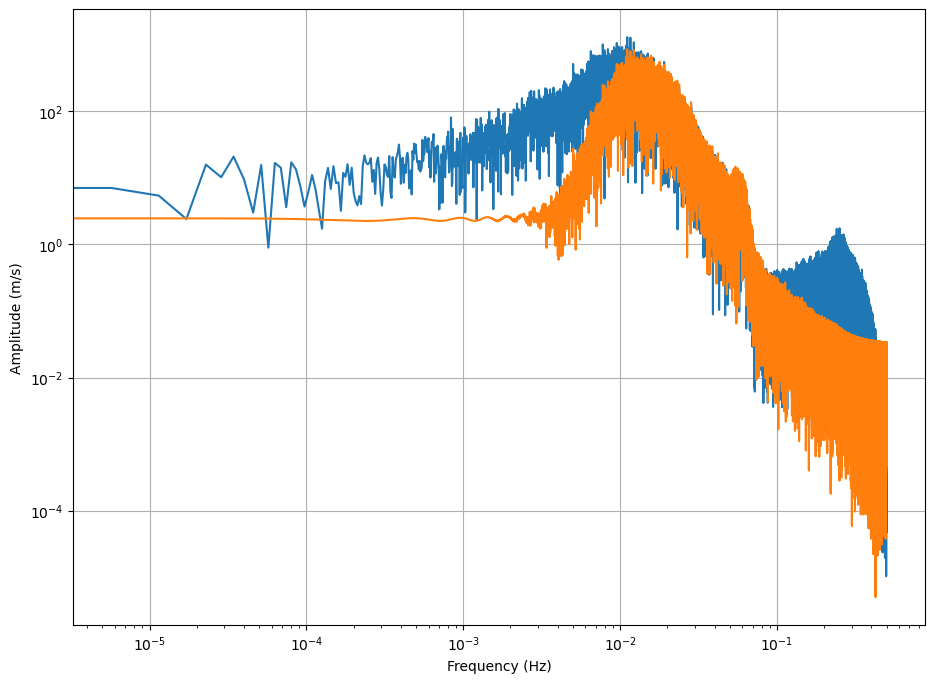

In [27]:
# import FFT modules
# answer below

from scipy.fftpack import fft, ifft, fftfreq, next_fast_len

npts = Z[0].stats.npts
Nfft = next_fast_len(int(Z[0].data.shape[0])) # this will be an even number
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfft)

fig,(ax1)=plt.subplots(1,1,figsize=(11,8))
ax1.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax1.grid(True)
ax1.set_xscale('log');ax1.set_yscale('log')
ax1.set_xlabel('Frequency (Hz)');ax1.set_ylabel('Amplitude (m/s)')

#For band pass filter
npts = Z[0].stats.npts
Nfftbp = next_fast_len(int(zf_bp.data.shape[0])) # this will be an even number
freqVecbp = fftfreq(Nfftbp, d=Z[0].stats.delta)[:Nfftbp//2]
Z.taper(max_percentage=0.05)
Zhatbp = fft(zf_bp.data,n=Nfftbp)

ax1.plot(freqVecbp,np.abs(Zhatbp[:Nfftbp//2])/Nfftbp)

Comment on the spectral content of the seismograms. How does the relative contribution of the low, intermediate, and high frequency signal compares with the relative amplitude observed in the bandpass filtered time series?

The Fourier transform has two peaks - one at 0.01 and the other one at around 0.15. Since the bandpass filters out between 0.01 to 0.1, only the peak at 0.01 is retained and all the frequencies after 0.1 are reduced down.

**d. Synthetic noise (3 points)**

We have now a good idea of what the amplitude of seismic waves are at this station. Now create a noise signal using the Fourier amplitude spectrum of the seismic signal, and with a random phase. You can use the notes from our first Numpy example (2.7_data_transforms.ipynb)

Text(0, 0.5, 'Amplitude (m/s)')

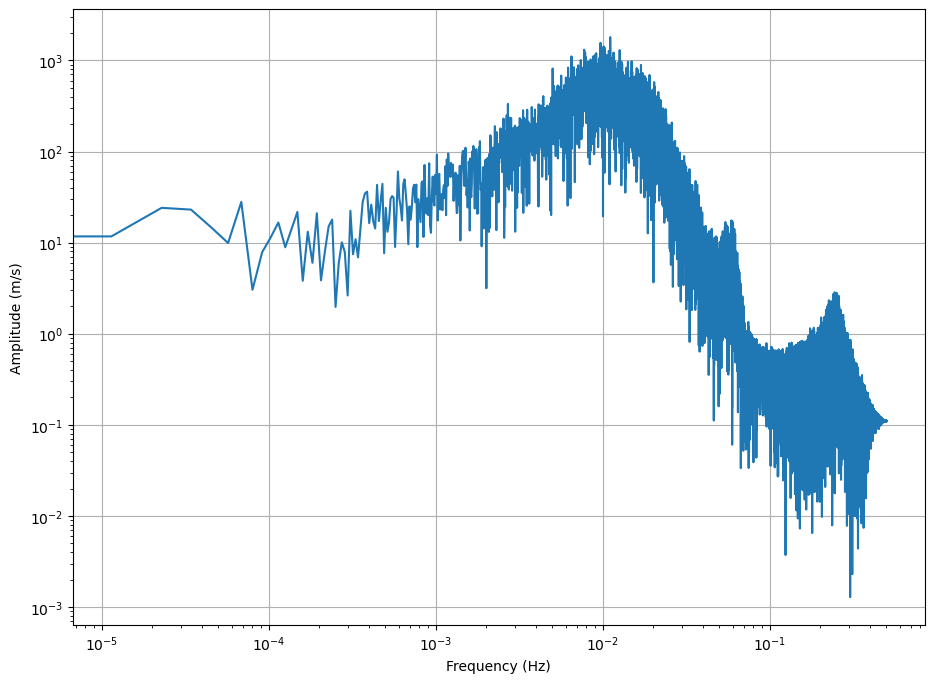

In [29]:

# answer below
from numpy import random
from scipy.fftpack import ifft,ifftshift 
noise = random.uniform(0,1,len(freqVec))
Nfftnoise = next_fast_len(int(noise.data.shape[0])) # this will be an even number
freqVecnoise = fftfreq(Nfftnoise, d=Z[0].stats.delta)[:Nfftnoise//2]
Z.taper(max_percentage=0.05)
Zhat = fft(Z[0].data,n=Nfftnoise)

fig,(ax1)=plt.subplots(1,1,figsize=(11,8))
ax1.plot(freqVecnoise,np.abs(Zhat[:Nfftnoise//2])/Nfftnoise)
ax1.grid(True)
ax1.set_xscale('log');ax1.set_yscale('log')
ax1.set_xlabel('Frequency (Hz)');ax1.set_ylabel('Amplitude (m/s)')


**e. !Sanity check! (1 point)**

Check that the Fourier amplitude spectrum of the noise is that of the original window. Overlay them on a plot 

Text(0, 0.5, 'Amplitude (m/s)')

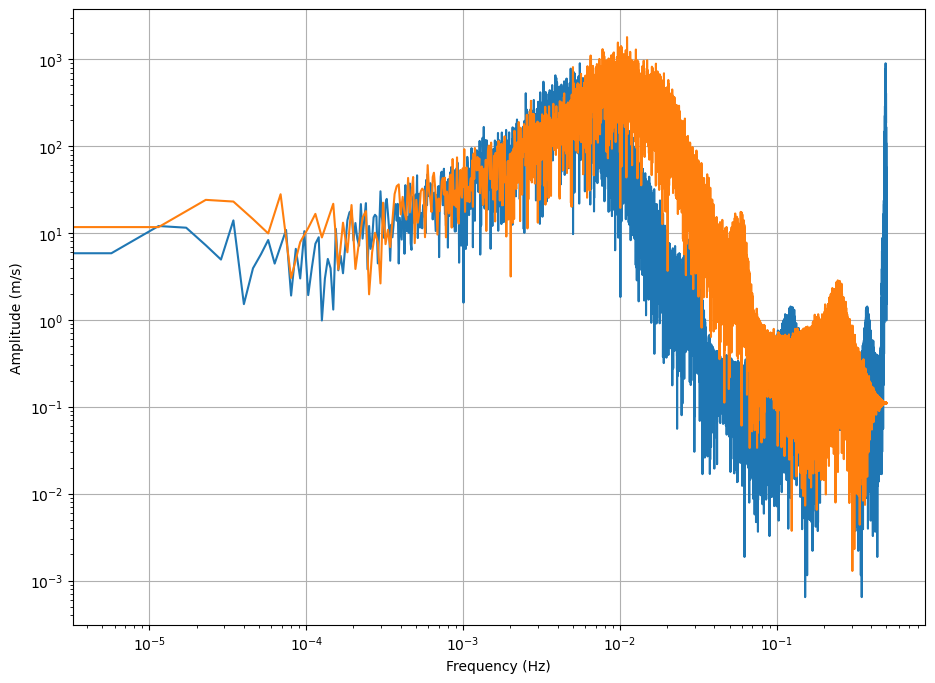

In [32]:
# answer below
fig,(ax1)=plt.subplots(1,1,figsize=(11,8))
ax1.plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax1.plot(freqVecnoise,np.abs(Zhat[:Nfftnoise//2])/Nfftnoise)
ax1.grid(True)
ax1.set_xscale('log');ax1.set_yscale('log')
ax1.set_xlabel('Frequency (Hz)');ax1.set_ylabel('Amplitude (m/s)')

**f. Short Time Fourier Transform (3 points)**

STFT are important transforms that are used in data science of time series. They are mainly used for denoising and for feature extraction.
Spectrograms are STFT with window overlap.

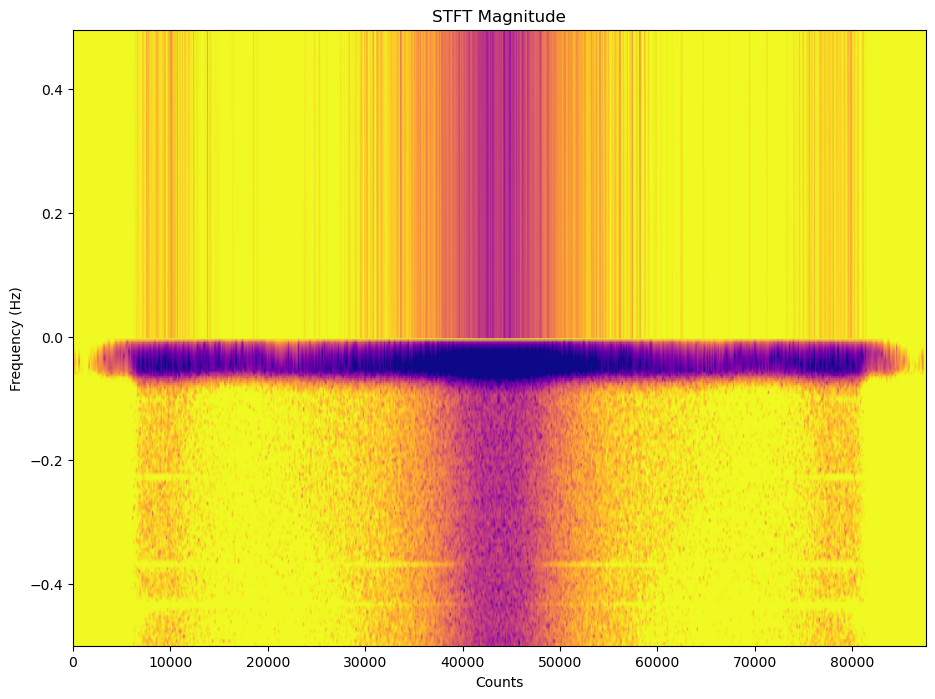

In [45]:
# answer below
from scipy.signal import stft
z=np.asarray(Zhat.data)
f, t, Zxx = stft(z, fs=fs)
fig,ax=plt.subplots(1,1,figsize=(11,8),sharex=True)
ax.pcolormesh(t, f, np.log10(np.abs(Zxx)), vmin=-1, vmax=3, shading='gouraud', cmap='plasma')
ax.set_title('STFT Magnitude');
ax.set_ylabel('Frequency (Hz)');
ax.set_xlabel('Counts');

Now you have created a 2D image of a time series! Many seismologists use that as input to convolutional neural networks.



## 2. Time Series analysis of Hunga- Tonga
 Ghent and Crowell, 2022: TF representation of the TEC (https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2022GL100145). The Total Electron Content (TEC) is the total number of electrons present along a path between a radio transmitter and receiver. TEC is measured in electrons per square meter. By convention, 1 TEC Unit TECU = 10^16 electrons/m². Vertical TEC values in Earth’s ionosphere can range from a few to several hundred TECU.

 On 15 January 2022, Tonga's Hunga Tonga-Hunga Ha'apai (HTHH) volcano violently erupted, generating a tsunami that killed three people. Acoustic-gravity waves propagated by the eruption and tsunami caused global complex ionospheric disturbances. In this paper, we study the nature of these perturbations from Global Navigation Satellite System observables over the southwestern Pacific. After processing data from 818 ground stations, we detect supersonic acoustic waves, Lamb waves, and tsunamis, with filtered magnitudes between 1 and 7 Total Electron Content units.

Apply the Fourier and Wavelet transforms to the TEC time series observed a a GPS section..


### a. Read the data (1 point)

Read the CSV file file ``./TEC/ioncorr_samo_015_2022_tonga.csv``, print the keys of the data frame. THe key ``time`` is a timestamp of seconds since epoch time (1970/01/01). The data shown in the article is in the Series ``variometric_derived_TEC``. **samo** is the name of the GPS receiver. There are up to 32 satellite data saved in the CSV file.

Plot the first 2 hours of the time series

In [49]:
# answer below
path = '../MLGeo-Autumn22/homework/TEC/ioncorr_samo_015_2022_tonga.csv'
data = pd.read_csv(path)
data.keys()

Index(['Unnamed: 0', 'GPS_seconds', 'satellite_number',
       'variometric_derived_TEC', 'variometric_derived_TEC_filtered',
       'absolute_derived_TEC', 'absolute_derived_TEC_filtered',
       'latitude_piercing_point', 'longitude_piercing_point',
       'satellite_azimuth', 'satellite_elevation_angle',
       'distance_to_piercing_point', 'time'],
      dtype='object')

Text(0, 0.5, 'Variometric derived TEC filtered')

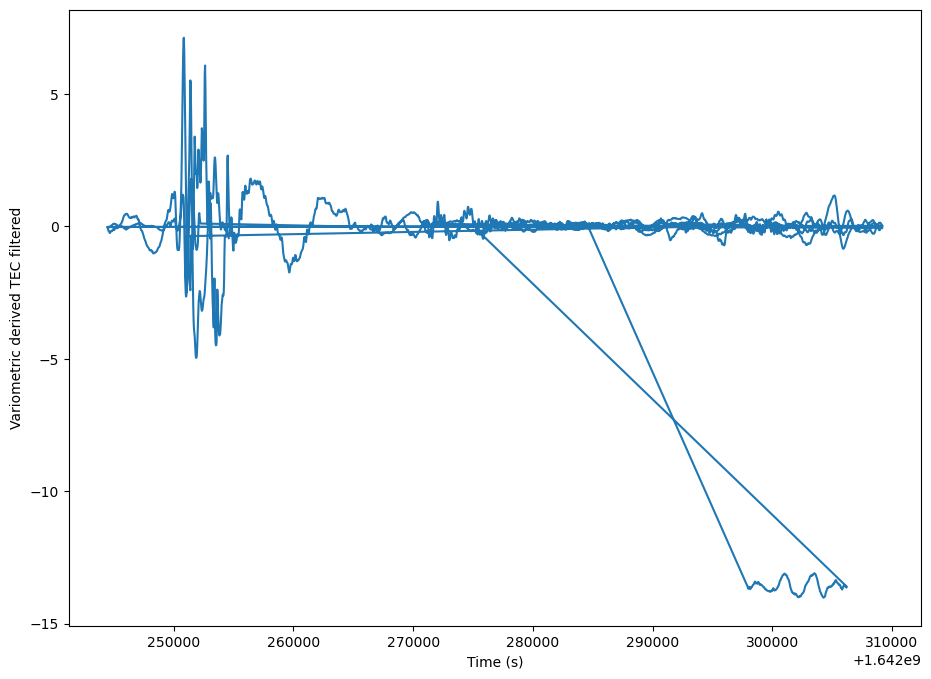

In [58]:
time_2hrs = data[['time']].head(7200)
vdt_2hrs = data[['variometric_derived_TEC']].head(7200)
fig, ax = plt.subplots(1,1,figsize=(11,8))
ax.plot(time_2hrs,vdt_2hrs)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Variometric derived TEC filtered')

## b. Get station info (0.5 point)
Get the station name by splitting the string of the file name and getting the charcater after "ioncorr". You can use the python function ``split()``.

In [59]:
# answer below
station_name = path.split("_")[1]

## c. Plot all data (2 points)
Make a plot of all vTEC filtered (``variometric_derived_TEC_filtered``) for each satellite. Align the data with the satellite number.

Use the ``plot_date`` function from matplotlib. Convert the Series ``time`` from a ``timestamp`` to an Numpy array of dtpe ``datetime64[s]`` (time stamps are in seconds, so we need to use ``[s]``). Plot the data for each sattelite observations.

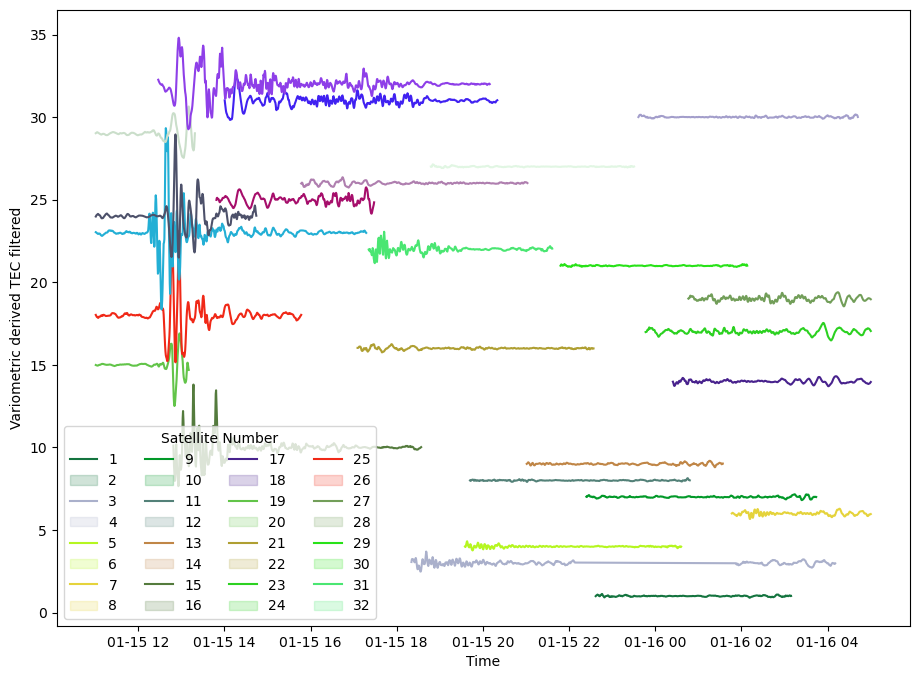

In [114]:
# answer below
import seaborn as sns
from matplotlib.pyplot import plot_date
fig, ax1 = plt.subplots(1, 1, figsize=(11,8))
for i in data['satellite_number'].unique():
    satellite_number_data = data.loc[data['satellite_number']==i]
    datatime = np.array(satellite_number_data['time'], dtype='datetime64[s]')
    color=tuple(np.random.random(3))
    sns.lineplot(x=datatime, y=satellite_number_data['variometric_derived_TEC_filtered']+satellite_number_data['satellite_number'], c=color)
ax1.set_xlabel('Time')
ax1.set_ylabel('Variometric derived TEC filtered')
ax1.legend(np.arange(1,33), ncol=4, title="Satellite Number");

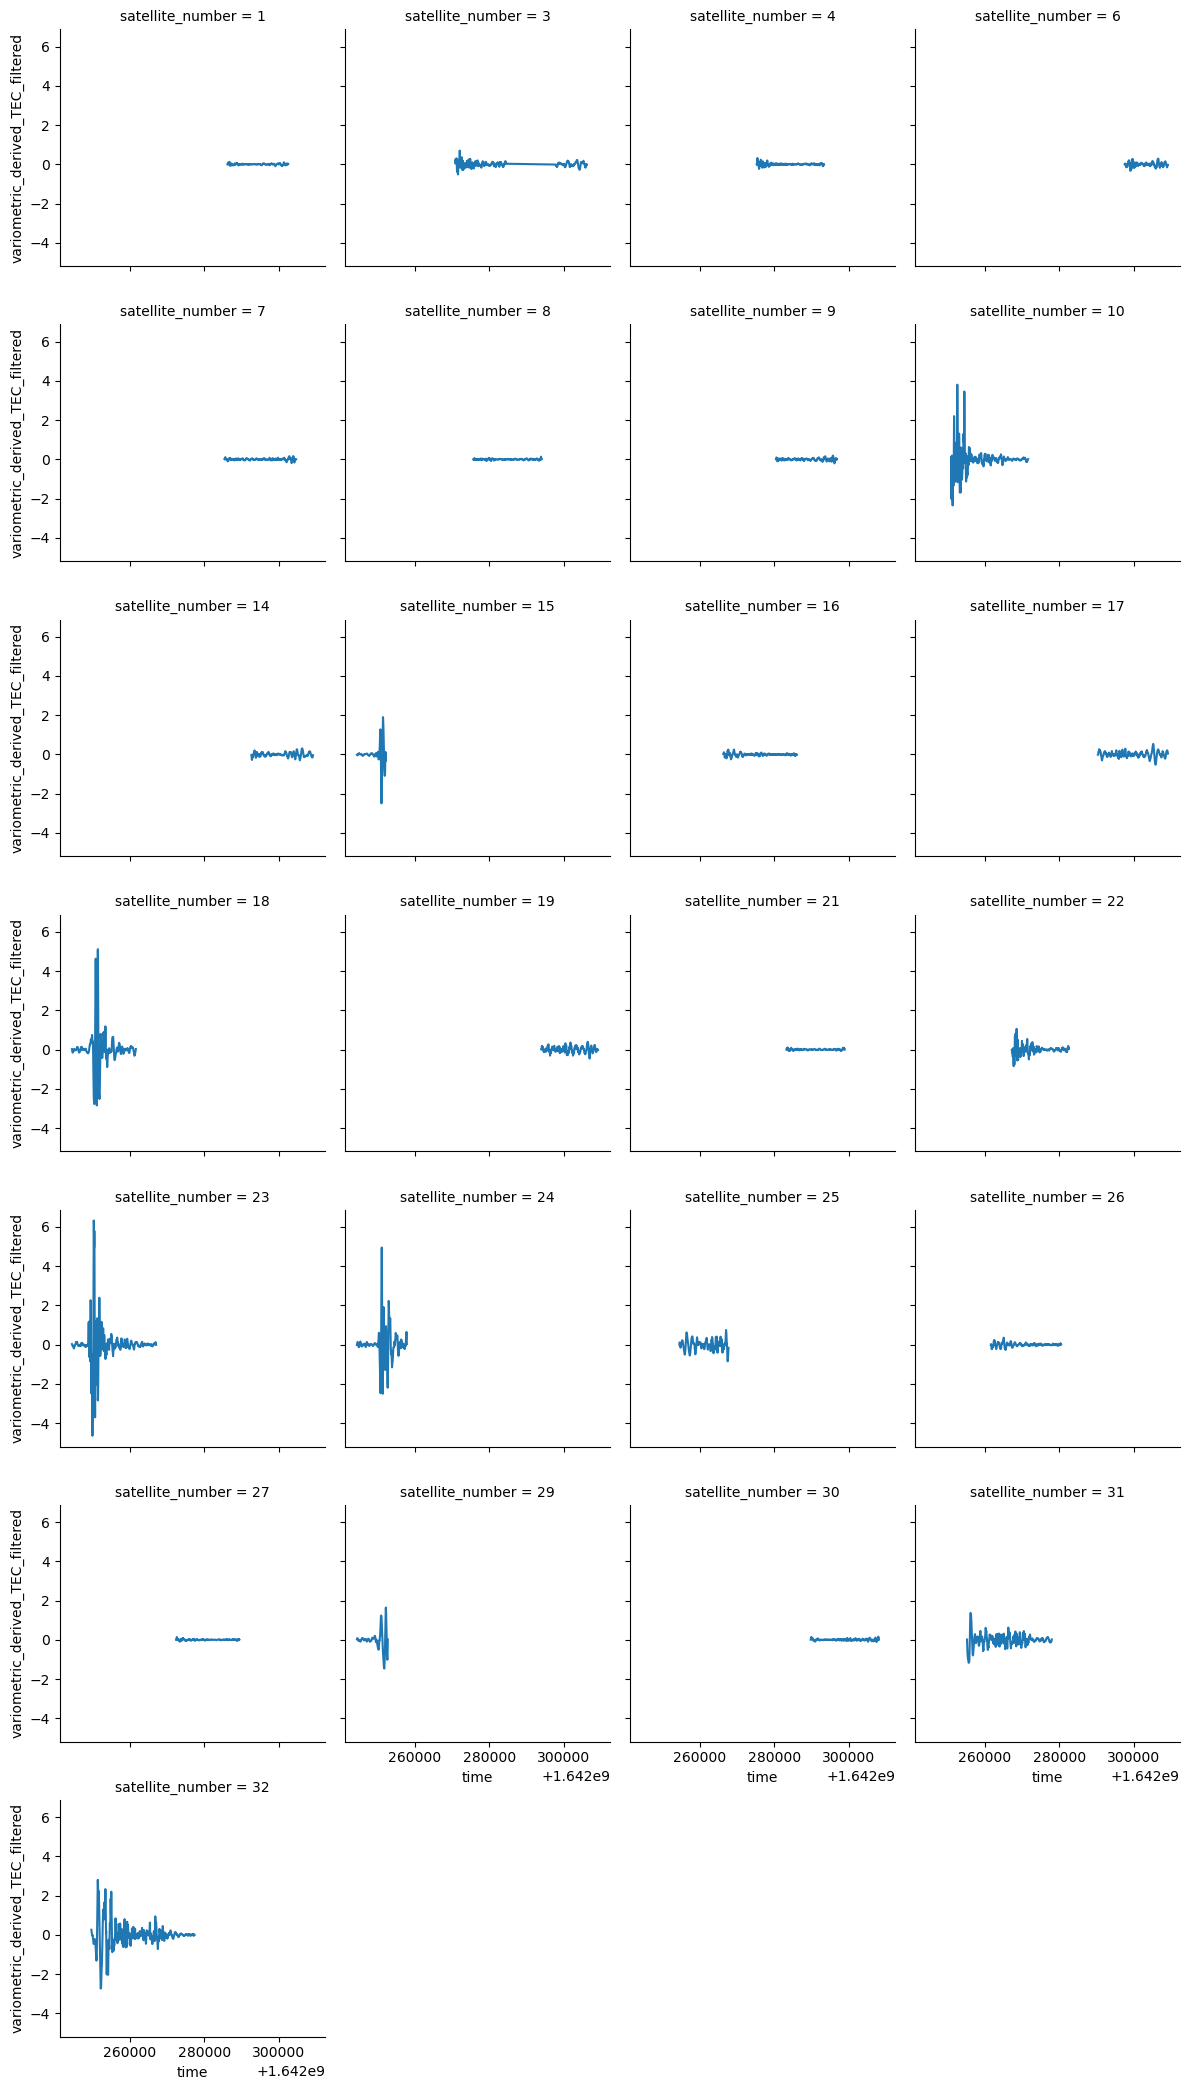

In [113]:
g = sns.FacetGrid(data, col="satellite_number", col_wrap=4, sharex=True)
g.map(sns.lineplot, "time", "variometric_derived_TEC_filtered")

You can now select one of the satellite observations that contain a full vTEC signal.

### d. Perform the wavelet transform (3 points)

Just like in the article, perform the wavelet transform using a Morlet transform. What can you tell about the time-frequency characteristic of these disturbances?

I chose the third satellite data because it has wider frequency range. This signal is heavily varying at the beginning and it reduces over time.

Text(0, 0.5, 'Variometric_derived_TEC_filtered')

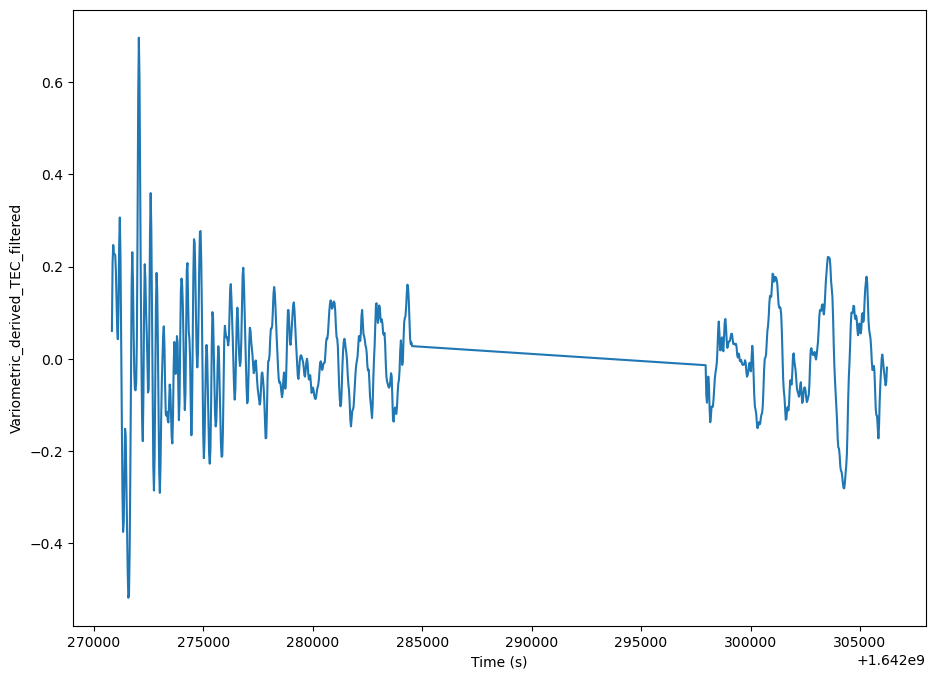

In [115]:
# answer below
#Selecting the third satellite data
satellite_first_data = data.loc[data['satellite_number']==3]
z=satellite_first_data['variometric_derived_TEC_filtered']
t=satellite_first_data['time']

fig, ax1 = plt.subplots(1,1,figsize=(11,8))
ax1.plot(t,z)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Variometric_derived_TEC_filtered")

Perform the wavelet transform.
Calculate the sampling frequency by taking the time difference between two samples.

In [128]:
#answer below
fs=int(t[546]-t[545])
fs

30

## d. Wavelet transform (3 points)
You may choose a range of wavelet scales from 1 to 50 (write this as an array of integer), and call the ``cwt`` functions using the Morlet wavelet and taking the array of scales as an input argument. Plot it with an x-axis in time (hours) and y-axis in periods.

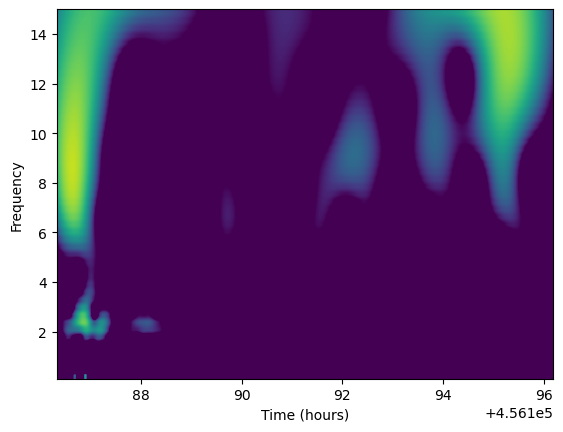

In [138]:
import scipy.signal as signal
# use the number of scales
w = range(1,50)

# answer below
freq = np.logspace(-1, np.log10(fs/2), 100)
cwtm = signal.cwt(z, signal.morlet2, w)

plt.imshow(np.log10(np.abs(cwtm)), extent=[t.min()/3600, t.max()/3600, freq.min(),freq.max()], cmap='viridis', aspect='auto',
           vmax=0, vmin=-0.5,origin='lower')
plt.xlabel('Time (hours)')
plt.ylabel('Frequency')
plt.show()

## e. Interpretation (0.5 points)
Can you describe the spectral features as a function of hours since the beginning of the time series? What periods dominate when?

(answer below)
In the sample I chose, there is high frequency at the beginning hours which subsided as time proceeds. After 94 hours, there is again heightened frequency which gets intensified towards 95 and 96th hour which is the end of the hours for this sample.

The authors interpret the first packet as coming from a Lamb wave (a powerful gravity-acoustic wave that travel in the lower atmosphere), the second as coming from the tsunami disturbance.

## 3) 2D Spectral analysis of geological models (10 points)

In this exercise we will correlate water table level with surface elevation. You may download the data just like in the class. The file names are ``NCM_GeologicFrameworksGrids.nc`` and ``NCM_SpatialGrid.nc``.


In the following we will prepare our data.

In [140]:
# insert below
!pip install wget
import wget
file1 = wget.download("https://www.dropbox.com/s/wdb25puxh3u07dj/NCM_GeologicFrameworkGrids.nc?dl=1")
# Download the coordinate grids
file2 = wget.download("https://www.dropbox.com/s/i6tv3ug15oe6yhe/NCM_SpatialGrid.nc?dl=1")
# Download the coordinate grids
file3 = wget.download("https://www.dropbox.com/s/92m20pehfu7rxp2/NCM_AuxData.nc?dl=1")

In [143]:
# insert below
import netCDF4 as nc
elevation=nc.Dataset(file1)
grid=nc.Dataset(file2)
WT=nc.Dataset(file3)

**a. Plot (2 points)**

Plot the data ``WT`` and ``elevation``. Use ``contourf``,``x`` and ``y`` as lat-long variables. You can use ``levels``  to split the color map, and ``alpha`` less than 1 to increase transparency.

In [151]:
# answer below
#print(grid)
x=grid['x'][0:2000, 0:1000]
y=grid['y'][0:2000, 0:1000]
elevationsurface=elevation['Surface Elevation'][0:2000, 0:1000]
watertable = WT['Water Table Depth'][0:2000, 0:1000]
# print(elevation)
# print(grid)
# print(WT)

Text(0, 0.5, 'Water Table Depth')

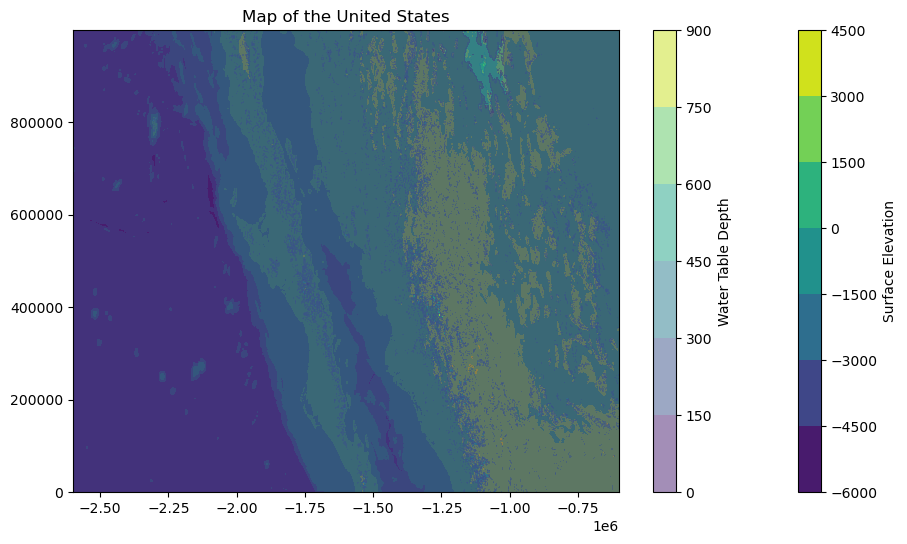

In [154]:
# plot below
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift
import matplotlib.cm as cm
import matplotlib.pyplot as plt
fig, (ax1) = plt.subplots(1,1, figsize=(11, 6))  
contour1=ax1.contourf(x, y, elevationsurface, levels=5)
contour2=ax1.contourf(x, y, watertable, levels=5, alpha=0.5)
plt.title('Map of the United States')        
cbar = fig.colorbar(contour1)
cbar.ax.set_ylabel('Surface Elevation')
cbar2 = fig.colorbar(contour2)
cbar2.ax.set_ylabel('Water Table Depth')

**b. Perform and plot the 2D Fourier transforms (4 points)**

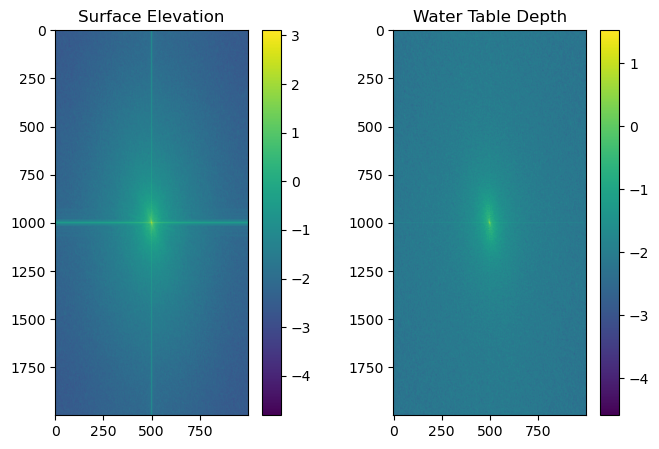

In [156]:
# answer below
from scipy.fftpack import fft2, fftfreq,fftshift

freqVec = fftfreq(len(elevationsurface))[:len(elevationsurface)//2]
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 5))  

Zel = fft2(elevationsurface)
elev=ax1.imshow(fftshift(np.log10(np.abs(Zel)/Zel.size)))
ax1.set_title('Surface Elevation');
cbar = fig.colorbar(elev);

Zwater = fft2(watertable)
water=ax2.imshow(fftshift(np.log10(np.abs(Zwater)/Zwater.size)))
ax2.set_title('Water Table Depth');
cbar2 = fig.colorbar(water);

**c. Interpretation (1 point)**

Comment on the wavelengths that dominate the DEM and the water table wavelengths

(answer below)

There is high frequency or low wavelength on surface elevation of 0 and 1. This could indicate the terrain is dominated with ground surface over mountains and other elevated structures. The depth of the water table that is frequently observed is at around 1 or 2 

**d. 2D filtering (3 points)**

Find a way to low pass filter the image (spectral filtering or convolution)

In [157]:
# solution
import scipy.signal as signal
sos1 = signal.butter(2,0.01, btype='lowpass', output='sos')
ZelFilt = signal.sosfiltfilt(sos1, Zel)
ZwaterFilt = signal.sosfiltfilt(sos1, Zwater)

Now we will filter or compress by taking the largest Fourier coefficients of the image.

In [158]:
# Sort the Fourier coefficients
from scipy.fftpack import ifft2
ZelSort = np.sort(np.abs(np.abs(ZelFilt).reshape(-1)))
ZwaterSort = np.sort(np.abs(np.abs(ZwaterFilt).reshape(-1)))
from IPython import display
import time
#Filter the surface elevation data
keep=0.01
thresh = ZelSort[int(np.floor( (1-keep)*len(ZelSort) ))]
ind = np.abs(Zel)>thresh
AtlowEl = Zel * ind 
AtlowEl = ifft2(AtlowEl).real

#The same for the water table data
thresh = ZwaterSort[int(np.floor( (1-keep)*len(ZwaterSort) ))]
ind = np.abs(Zwater)>thresh
AtlowWater = Zwater * ind 
AtlowWater = ifft2(AtlowWater).real

keep=0.1
thresh = ZwaterSort[int(np.floor( (1-keep)*len(ZwaterSort) ))]
ind = np.abs(Zwater)>thresh
AtlowWater10 = Zwater * ind 
AtlowWater10 = ifft2(AtlowWater10).real

Plot and reconstruct the image of the water table map with 1% until 10% of the data (like in class)

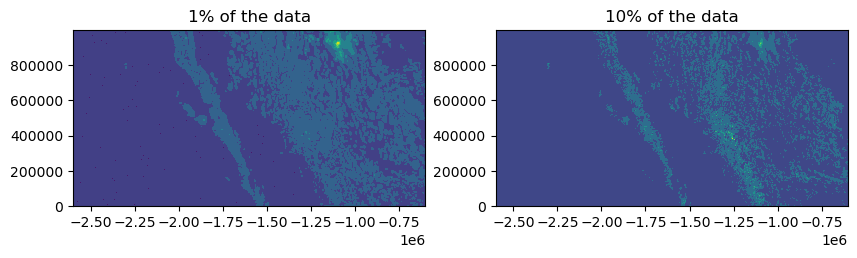

In [159]:

#snwer below
from IPython import display
import time
fig,ax=plt.subplots(1,2,figsize=(10,8),sharex=True)
ax[0].contourf(x, y, AtlowWater);ax[0].set_title('1% of the data')
ax[0].axis('scaled');
ax[1].contourf(x, y, AtlowWater10);ax[1].set_title('10% of the data')
ax[1].axis('scaled');

Now we will compare the original 2D data set with the Fourier compressed data


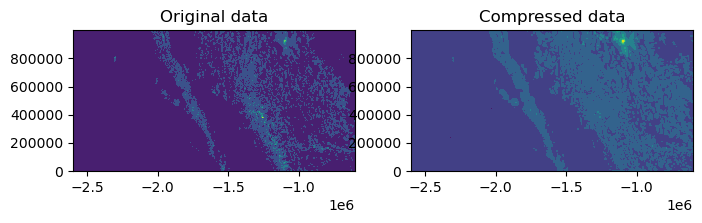

In [160]:
# answer below
fig,ax=plt.subplots(1,2,figsize=(8,8),sharex=True)
ax[0].contourf(x, y, waterTableDepth);ax[0].set_title('Original data')
ax[0].axis('scaled');
ax[1].contourf(x, y, AtlowWater);ax[1].set_title('Compressed data')
ax[1].axis('scaled');